# Header

<img src="http://reiner-lemoine-institut.de//wp-content/uploads/2015/09/rlilogo.png" width="100" style="float: right">

__copyright__ 	= "© Reiner Lemoine Institut" <br>
__license__ 	= "GNU Affero General Public License Version 3 (AGPL-3.0)" <br>
__url__ 		= "https://www.gnu.org/licenses/agpl-3.0.en.html" <br>
__author__ 		= "Ludwig Hülk" <br>

# Import

In [2]:
import sys
import os
import getpass
import pandas as pd
import numpy as np
from sqlalchemy import *
# plot
import matplotlib.pyplot as plt
import matplotlib.ticker as mticker
import plotly.graph_objs as go
import plotly.offline as pltly
import colorlover as cl
import seaborn as sns
#import cufflinks as cf
# notebook
from IPython.display import Image
from IPython.core.display import HTML 

pltly.init_notebook_mode(connected=True)
%matplotlib inline

version = 'v0.1.3 (jupyther)'
project = 'REEEM'

# Database Connection

This function creates a database connection to the **reeem_db**.<br>
The default user is **reeem_vis**, a user that has only read rights.

In [3]:
def reeem_session():
    """SQLAlchemy session object with valid connection to reeem database"""
    
    print('Please provide connection parameters to database:\n' +
              'Hit [Enter] to take defaults')
    host = '130.226.55.43' # input('host (default 130.226.55.43): ')
    port = '5432' # input('port (default 5432): ')
    database = 'reeem' # input("database name (default 'reeem'): ")
    user = 'reeem_vis' # input('user (default postgres): ')
    # password = input('password: ')
    password = getpass.getpass(prompt='password: ',
                                   stream=sys.stderr)
    con = create_engine(
            'postgresql://' + '%s:%s@%s:%s/%s' % (user,
                                                  password,
                                                  host,
                                                  port,
                                                  database)).connect()
    print('Password correct! Database connection established.')
    return con

# Access Data

This section establishes the database connection and asks for the **password**.<br>
The username can be changed in the corresponding function in the section **Database Connection** above.<br>
If you don't have a username or forgot your password please contact your database admins.

In [4]:
con = reeem_session()

C:\Anaconda3\envs\reeem-vis\lib\site-packages\ipykernel_launcher.py:12: UserWarning:

The `stream` parameter of `getpass.getpass` will have no effect when using ipykernel



Please provide connection parameters to database:
Hit [Enter] to take defaults
password: ········
Password correct! Database connection established.


# View 0.1: Existing entries in one column

## Database Query

This section can be used to query one specific database **column** from one database table (**FROM**).<br>
The result is saved to a pandas.DataFrame (**df_0**) and printed.

In [5]:
# Database select (SQL)
column = 'pathway' # id, pathway, version, region, year, indicator, category, value, unit
sql = text("""
    SELECT  {0} 
    FROM    model_draft.reeem_times_paneu_output 
    GROUP BY {0} 
    ORDER BY {0}; """.format(column))
df_0 = pd.read_sql_query(sql, con)
print(df_0)

                pathway
0                  Base
1  Base(withRen.Target)
2               HighRES
3                 Pilot
4                Pilot2
5          StorageInnov


# View 0.2: Search for existing indicators

## Database Query

This section can be used to search for one specific **indicator** and its **nid** in one database table.<br>
The documentation of the **LIKE** expression is [here](https://www.postgresql.org/docs/current/static/functions-matching.html#FUNCTIONS-LIKE). 
The result is printed.<br>
Hint: If one indicator has multiple nid it is a bug!

In [6]:
# Database select (SQL)
sql = text("""
    SELECT  nid, category, indicator
    FROM    model_draft.reeem_times_paneu_output 
    WHERE   category LIKE 'Emissions%' 
            AND indicator = 'CO2' 
    GROUP BY nid, category , indicator
    ORDER BY nid, category , indicator; """)
df_0 = pd.read_sql_query(sql, con)
print(df_0)

   nid                              category indicator
0  867  Emissions by Emittant and Sector_CO2       CO2
1  891  Emissions by Emittant and Sector_CO2       CO2
2  933  Emissions by Emittant and Sector_CO2       CO2
3  957  Emissions by Emittant and Sector_CO2       CO2


# View 2: One indicator for one region in different pathways over time

## Database Query

This section can be used to query one specific **indicator** (_filter 1_) for one specific **region** (_filter 2_) from one database table (_table_).<br>
Indicators are identified by the **nid**.<br>
It is possible to select one specific **pathway** (_filter 3_) and one specific data **version** (_filter 4_).<br>
To querry additional coulmns from the database table add the names to the **SELECT** statement (_column_).<br>
The sortation is done by the **ORDER BY** (_sorting_).<br>
The result from the database is saved to a pandas.DataFrame (**df_2**) and can be printed.

In [7]:
# Database select (SQL)
sql = text("""
    SELECT  pathway, version, region, year, indicator, category, value, unit  -- column
    FROM    model_draft.reeem_times_paneu_output  -- table
    WHERE nid = 867                               -- filter 1
        AND region = 'EU28'                       -- filter 2
        AND (pathway = 'Base' 
            OR pathway = 'HighRES' 
            OR pathway = 'StorageInnov')          -- filter 3
        AND version = 'DataV1'                    -- filter 4
    ORDER BY pathway, version, year;              -- sorting """)
df_2 = pd.read_sql_query(sql, con)
# print(df_2)

## Metadata

The important information from the above select (**df_2**) is collected in a Dictionary (**info_dict_2**).

In [8]:
# Facts dict
info_dict_2 = {}
info_dict_2['Filename'] = ['{}_reeem_plot_2' .format(pd.to_datetime('today').strftime("%Y-%m-%d"))]
info_dict_2['Category'] = df_2.loc[:,'category'].unique()
info_dict_2['Indicator'] = df_2.loc[:,'indicator'].unique()
info_dict_2['Unit'] = df_2.loc[:,'unit'].unique()
info_dict_2['Pathway'] = df_2.loc[:,'pathway'].unique()
info_dict_2['Year'] = df_2.loc[:,'year'].unique().tolist()
info_dict_2['Region'] = df_2.loc[:,'region'].unique()
info_dict_2['Y-Axis'] = ['{} in {}'.format(*info_dict_2['Indicator'], *info_dict_2['Unit'])]
info_dict_2['Title'] = ['{} in {}'.format(*info_dict_2['Category'], *info_dict_2['Region'])]
# ToDo: Select metadata string from database table and also add!

# Print facts
for x in info_dict_2:
    print(x,':',info_dict_2[x])

Filename : ['2018-09-27_reeem_plot_2']
Category : ['Emissions by Emittant and Sector_CO2']
Indicator : ['CO2']
Unit : ['Mt']
Pathway : ['Base' 'HighRES' 'StorageInnov']
Year : [2015, 2020, 2025, 2030, 2035, 2040, 2045, 2050]
Region : ['EU28']
Y-Axis : ['CO2 in Mt']
Title : ['Emissions by Emittant and Sector_CO2 in EU28']


## Stack data

This pivot function reorganises the data and makes each pathway a column. The year is used as the index.<br>
The result is saved to a new dataframe (**df_2p**) and can be printed.

In [9]:
# Reshape dataframe
df_2p = df_2.pivot(index='year', columns='pathway',  values='value')
# print (df_2p)

## Plot

This is a basic plot with [matplotlib](https://matplotlib.org/).<br>
The title and y-axis labels are taken from the **info_dict_2**. They can be exchanged with manual text.

(0, 3616.4252500000002)

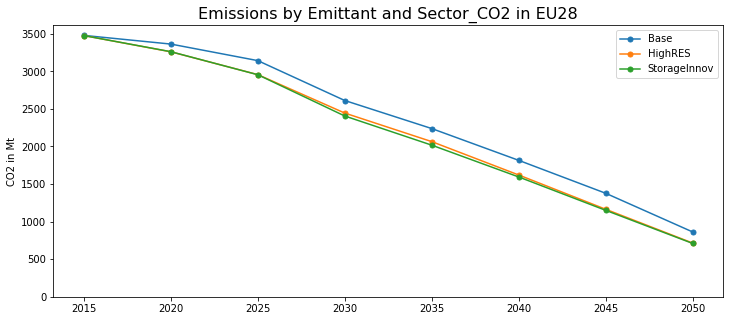

In [10]:
# Plot for one indicator and one pathway
fig_2 = plt.figure(figsize=(12, 5))
ax = plt.subplot()
# plt.title(r'CO2-Emissions in EU28', fontsize=16)  # Manual title
plt.title(*info_dict_2['Title'], fontsize=16)         # Title from info
# plt.ylabel(r'CO2-Emissions in Mt')                # Manual label
plt.ylabel(*info_dict_2['Y-Axis'])                    # Label from info
plt.plot(df_2p, 
         marker="o",  markersize=5)
plt.legend(df_2p)
ax.set_ylim(ymin=0)

## Interactive Plot

This is a basic interactive plot with [Plotly](https://plot.ly/python/).<br>
You can hover over the elements of the plot and observe the data.<br>
The different pathways can be switched on and off.

In [11]:
# Iterate over pathways and add to data
pathways = df_2.loc[:,'pathway'].unique()
data = []
for pathway in pathways:
    data.append(go.Scatter(
        x = df_2.loc[df_2['pathway'] == pathway].loc[:,'year'],
        y = df_2.loc[df_2['pathway'] == pathway].loc[:,'value'],
        name = pathway))

# Set layout
layout = go.Layout(
    height=400, width = 800,
    #title='CO2-Emissions in EU28',
    title=''.join(info_dict_2['Title']),
    # yaxis=dict(title='CO2-Emissions in Mt') )
    yaxis=dict(title=''.join(info_dict_2['Y-Axis'])) )
ifig = go.Figure(data=data, layout=layout)
pltly.iplot(ifig)

## Interactive Plot 2

This is the manual interactive version.<br>
You can control the design using the [plotly documentation](https://plot.ly/python/line-and-scatter/#line-and-scatter-plots).

In [ ]:
data = [go.Scatter(x=df_2.loc[df_2['pathway'] == 'Base'].loc[:,'year'],
                   y=df_2.loc[df_2['pathway'] == 'Base'].loc[:,'value'],
                   mode='lines+markers',
                   line=dict(color='black', dash='none', width='2'),
                   marker=dict(symbol='o', size=8, line=dict(width=2, color='black')),
                   name='Base'
                  ),
        go.Scatter(x=df_2.loc[df_2['pathway'] == 'HighRES'].loc[:,'year'],
                   y=df_2.loc[df_2['pathway'] == 'HighRES'].loc[:,'value'],
                   mode='lines+markers',
                   line=dict(color='green', dash='', width='2'),
                   marker=dict(symbol='o', size=5, line=dict(width=2, color='black')),
                   name='HighRES'
                  ),
        go.Scatter(x=df_2.loc[df_2['pathway'] == 'StorageInnov'].loc[:,'year'],
                   y=df_2.loc[df_2['pathway'] == 'StorageInnov'].loc[:,'value'],
                   line=dict(color='red', dash='dash', width='2'),
                   marker=dict(symbol='o', size=5, line=dict(width=2, color='black')),
                   name='StorageInnov'
                  )
       ]
layout = go.Layout(
    height=400, width = 800,
    #title='CO2-Emissions in EU28',
    title=''.join(info_dict_2['Title']),
    # yaxis=dict(title='CO2-Emissions in Mt') )
    yaxis=dict(title=''.join(info_dict_2['Y-Axis'])) )
ifig2 = go.Figure(data=data, layout=layout)
pltly.iplot(ifig2)

## Save results to files

The results are saved to cooresponding files in a folder named **data**.<br>
The **info_dict** is saved to a text file (txt).<br>
The **data** is saved to a table (csv).<br>
The **plot** is saved as an image (png).<br>
The **interactive plot** is saved as a webpage (html). It will also open in a new tab of your browser.<br>

In [ ]:
# Write facts to textfile
filename = ('data/{}.txt').format(*info_dict_2['Filename'])
with open(filename,'w') as tfile:
    for i in info_dict_2.keys():
        tfile.write(i + ": " + ', '.join([str(x) for x in info_dict_2[i]]) + "\n")
tfile.close()
print("Facts saved to file:", filename)

# Save data to CSV
csvname = 'data/{}.csv' .format(*info_dict_2['Filename'])
df_2.to_csv(csvname, sep=';')
print("Data saved to file:", csvname)

# Save pivot data to CSV
csvname = 'data/{}_pivot.csv' .format(*info_dict_2['Filename'])
df_2p.to_csv(csvname, sep=';')
print("Data saved to file:", csvname)

# Save plot as file
plotname = 'data/{}.png' .format(*info_dict_2['Filename'])
fig_2.savefig(plotname, bbox_inches='tight')
print("Plot saved to file:", plotname)

# Save interactive plot
htmlname = 'data/{}.html' .format(*info_dict_2['Filename'])
pltly.plot(ifig, filename=htmlname)
print("Interactive plot saved to file:", htmlname)

# Save interactive plot 2
htmlname = 'data/{}_2.html' .format(*info_dict_2['Filename'])
pltly.plot(ifig2, filename=htmlname)
print("Interactive plot saved to file:", htmlname)